# Tries

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from functools import partial
from pathlib import Path

import gymnasium as gym
import numpy as np
import seaborn as sns
import torch
import torchinfo
from beartype import beartype as typechecker
from rich.pretty import pprint as pp
from torch import Tensor, nn
from torch.nn import functional as F

from bert_sac.models import Actor, AttentionLayer, SoftQNetwork
from bert_sac.sac_trainer import AntSAC, AntSACConfig
from bert_sac.utils import make_env

ppe = partial(pp, expand_all=True)

device = torch.device("cuda:0")
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)
torch.set_float32_matmul_precision("high")

In [3]:
SEED = 96

ATT_MASK = torch.tensor(
    [
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    ]
)
ATT_MASK.shape

torch.Size([27, 27])

In [4]:
envs = gym.vector.AsyncVectorEnv([make_env("Ant-v4") for _ in range(16)])

In [5]:
X = torch.tensor(envs.reset()[0])
# X.unsqueeze_(-1)
X.shape

torch.Size([16, 27])

In [6]:
weights_shape = (1, 1, 256)

W_q = nn.Parameter(torch.randn(weights_shape))
W_k = nn.Parameter(torch.randn(weights_shape))
W_v = nn.Parameter(torch.randn(weights_shape))

b_q = nn.Parameter(torch.randn(weights_shape))
b_k = nn.Parameter(torch.randn(weights_shape))
b_v = nn.Parameter(torch.randn(weights_shape))

In [7]:
query = nn.Linear(27, 256)
key = nn.Linear(27, 256)
value = nn.Linear(27, 256)

In [8]:
# Q = X @ W_q + b_q
# K = X @ W_k + b_k
# V = X @ W_v + b_v
Q = query(X).unsqueeze(-1)
K = key(X).unsqueeze(-1)
V = value(X).unsqueeze(-1)
Q.shape


torch.Size([4, 256, 1])

In [9]:
multihead_attn = nn.MultiheadAttention(embed_dim=1, num_heads=1, batch_first=True)
multihead_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=1, out_features=1, bias=True)
)

In [12]:
# attn_output, attn_output_weights = multihead_attn(Q, K, V, attn_mask=ATT_MASK.to(torch.bool))

In [13]:
# attn_output.shape, attn_output_weights.shape

In [14]:
# sns.heatmap(attn_output.squeeze(-1).cpu().detach().numpy())

In [17]:
att = AttentionLayer(ATT_MASK.unsqueeze(0), 256)

In [18]:
att(X).shape

torch.Size([16, 27])

<Axes: >

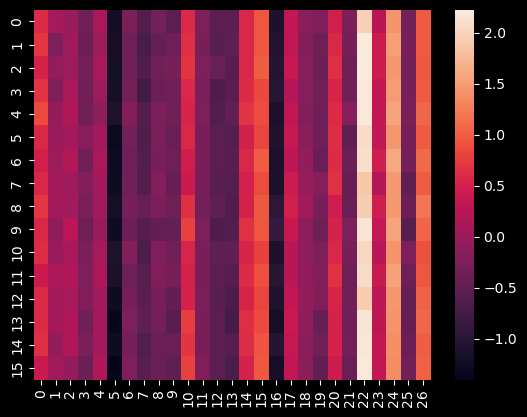

In [19]:
sns.heatmap(att(X).squeeze(-1).cpu().detach().numpy())

## Attention seeking

### Explorations

In [18]:
envs = gym.vector.AsyncVectorEnv([make_env("Ant-v4", seed=SEED) for _ in range(4)])
sac_config = AntSACConfig(n_legs=4, seed=SEED, checkpoint_frequency=20_000)

sac = AntSAC(
    actor_net=Actor,
    critic_net=SoftQNetwork,
    envs=envs,
    num_obs=27,
    num_act=8,
    device=device,
    attention_mask=ATT_MASK,
    config=sac_config,
    artifact_path="./artifacts",
    num_att_layers=3,
)
sac.global_step

0

In [24]:
obs_sample = torch.tensor(envs.reset()[0])
action_sample, _, _ = sac.actor.get_action(obs_sample)
obs_sample.shape

torch.Size([4, 27])

In [28]:
torchinfo.summary(sac.actor, input_data=obs_sample)

Layer (type:depth-idx)                   Output Shape              Param #
Actor                                    [4, 8]                    --
├─Sequential: 1-1                        [4, 27]                   --
│    └─AttentionLayer: 2-1               [4, 27]                   96
│    │    └─Softmax: 3-1                 [4, 27, 27]               --
│    └─AttentionLayer: 2-2               [4, 27]                   96
│    │    └─Softmax: 3-2                 [4, 27, 27]               --
│    └─AttentionLayer: 2-3               [4, 27]                   96
│    │    └─Softmax: 3-3                 [4, 27, 27]               --
├─Sequential: 1-2                        [4, 256]                  --
│    └─Linear: 2-4                       [4, 256]                  7,168
│    └─ReLU: 2-5                         [4, 256]                  --
│    └─Linear: 2-6                       [4, 256]                  65,792
│    └─ReLU: 2-7                         [4, 256]                  --
├─Linear

In [27]:
torchinfo.summary(sac.qf1, input_data=(obs_sample, action_sample))

Layer (type:depth-idx)                   Output Shape              Param #
SoftQNetwork                             [4, 1]                    --
├─Sequential: 1-1                        [4, 27]                   --
│    └─AttentionLayer: 2-1               [4, 27]                   96
│    │    └─Softmax: 3-1                 [4, 27, 27]               --
│    └─AttentionLayer: 2-2               [4, 27]                   96
│    │    └─Softmax: 3-2                 [4, 27, 27]               --
│    └─AttentionLayer: 2-3               [4, 27]                   96
│    │    └─Softmax: 3-3                 [4, 27, 27]               --
├─Sequential: 1-2                        [4, 1]                    --
│    └─Linear: 2-4                       [4, 256]                  9,216
│    └─ReLU: 2-5                         [4, 256]                  --
│    └─Linear: 2-6                       [4, 256]                  65,792
│    └─ReLU: 2-7                         [4, 256]                  --
│    └─L

### Determination

In [7]:
batch_size = 500
num_obs = 27
hidden_dim = 768

In [26]:
X = torch.rand((batch_size, num_obs))
X.shape

torch.Size([500, 27])

In [27]:
W_q = torch.rand((1, 1, hidden_dim))
W_k = torch.rand((1, 1, hidden_dim))
W_v = torch.rand((1, 1, hidden_dim))
W_q.shape

torch.Size([1, 1, 768])

In [21]:
Q = X @ W_q
K = X @ W_k
Q.shape, K.shape

(torch.Size([500, 27, 768]), torch.Size([500, 27, 768]))

In [24]:
(Q @ K.mT).shape

torch.Size([500, 27, 27])

In [22]:
torch.rand((1, 4, 1)) * torch.rand((1, 4, 1))

tensor([[[0.3329],
         [0.0205],
         [0.0808],
         [0.1528]]])

In [28]:
@jaxtyped(typechecker=typechecker)
def self_attention(
    X: Float[Tensor, "batch num_obs"],
    W_q: Float[Tensor, "1 1 hidden_dim"],
    W_k: Float[Tensor, "1 1 hidden_dim"],
    W_v: Float[Tensor, "1 1 hidden_dim"],
) -> Float[Tensor, "batch num_obs"]:
    X = X.unsqueeze(-1)
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    scores = Q @ K.mT
    soft_scores = F.softmax(scores, dim=1)
    soft_scores_value = soft_scores @ V
    Z = torch.sum(soft_scores_value, dim=2)

    return Z


In [29]:
self_attention(X, W_q, W_k, W_v).shape

torch.Size([500, 27])

### Attention Layer

In [30]:
from libs.bert_sac.models import AttentionLayer

In [39]:
INPUT = torch.tensor([[2], [3], [4], [5]], dtype=torch.float64).T
MASK = torch.tensor(
    [[1, 1, 1, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 1]], dtype=torch.float64
).unsqueeze(0)
INPUT.shape, MASK.shape

(torch.Size([1, 4]), torch.Size([1, 4, 4]))

In [40]:
att = AttentionLayer(mask=MASK, hidden_dim=10)

In [41]:
att(INPUT).shape

torch.Size([1, 4])

In [25]:
MASK = torch.sum(MASK, dim=0)

In [26]:
MASK

tensor([[1., 1., 1., 1.],
        [1., 1., 0., 0.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [27]:
at1 = AttentionLayer(mask=MASK, hidden_dim=3)
at2 = AttentionLayer(mask=MASK, hidden_dim=2)
at3 = AttentionLayer(mask=MASK, hidden_dim=1)

In [31]:
out1 = at1(INPUT)
out1.shape

torch.Size([1, 4, 1])

In [29]:
INPUT.shape

torch.Size([1, 4, 1])

In [ ]:
class Unsqueeze(nn.Module):
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.dim = dim

    def forward(self, input):
        return torch.unsqueeze(input, dim=self.dim)


In [ ]:
class Logger(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        pp(input.shape)
        return input

In [ ]:
X.shape

torch.Size([500, 27, 1])

In [42]:
attention = nn.Sequential(
    AttentionLayer(mask=MASK, hidden_dim=3),
    # nn.LogSigmoid(),
    AttentionLayer(mask=MASK, hidden_dim=6),
    # nn.LogSigmoid(),
    AttentionLayer(mask=MASK, hidden_dim=10),
    nn.Softmax(dim=1),
)
attention

Sequential(
  (0): AttentionLayer(
    (softmax): Softmax(dim=1)
  )
  (1): AttentionLayer(
    (softmax): Softmax(dim=1)
  )
  (2): AttentionLayer(
    (softmax): Softmax(dim=1)
  )
  (3): Softmax(dim=1)
)

In [43]:
attention(INPUT).shape

torch.Size([1, 4])

In [36]:
xml_model_dir = Path("assets/mujoco/models/").resolve()

# env = gym.make("mujoco/AntLegs", num_obs_shape=23)
env = AntLegsEnv(xml_file=str(xml_model_dir / "ant-4.xml"), num_obs_shape=23)
env.reset()

(array([ 0.67828191,  0.99187564, -0.08182384, -0.02428967,  0.09432701,
        -0.08823338, -0.08624539,  0.03419562,  0.06192357, -0.00637809,
        -0.09349867,  0.03813239, -0.04823608,  0.0539466 ,  0.18757243,
         0.10327583,  0.01380006, -0.0580944 ,  0.01756549,  0.05170134,
        -0.00533312, -0.03364654,  0.08338443, -0.08010723, -0.07993817,
         0.02429204, -0.1592504 ]),
 {})

In [43]:
from functools import reduce
from operator import mul

if env.observation_space.shape:
    print(reduce(mul, env.observation_space.shape))

23


In [ ]:
att_mask = [
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 6,
    [1] * 5 + [0] * 2 + [1] * 2 + [0] * 4 + [1] * 6 + [0] * 2 + [1] * 2 + [0] * 4,
    [1] * 5 + [0] * 4 + [1] * 2 + [0] * 2 + [1] * 6 + [0] * 4 + [1] * 2 + [0] * 2,
    [1] * 5 + [0] * 6 + [1] * 2 + [0] * 0 + [1] * 6 + [0] * 6 + [1] * 2 + [0] * 0,
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 6,
    [0] * 7 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 4,
    [0] * 9 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 2,
    [0] * 11 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 0,
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 6 + [0, 1, 0, 1, 0, 1, 0] + [1] * 7 + [0, 1, 0, 1, 0, 1, 0],
    [1] * 7 + [0] * 6 + [1] * 8 + [0] * 6,
    [1] * 5 + [0] * 2 + [1] * 2 + [0] * 4 + [1] * 6 + [0] * 2 + [1] * 2 + [0] * 4,
    [1] * 5 + [0] * 4 + [1] * 2 + [0] * 2 + [1] * 6 + [0] * 4 + [1] * 2 + [0] * 2,
    [1] * 5 + [0] * 6 + [1] * 2 + [0] * 0 + [1] * 6 + [0] * 6 + [1] * 2 + [0] * 0,
    [0] * 5 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 6,
    [0] * 7 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 4,
    [0] * 9 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 2,
    [0] * 11 + [1] * 2 + [0] * 12 + [1] * 2 + [0] * 0,
]
np.array(att_mask)

array([[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 